# Toy 6: Example Described in One Layer

In [20]:
import torch
from kan import create_dataset
from kan.custom import MultKAN
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

f = lambda x: torch.log(20*((x[:, [0]])+1.2)) + x[:, [1]]
dataset = create_dataset(f, n_var=2, train_num=1000, test_num=100, device=device, normalize_label=True)

| train_loss: 1.34e-02 | test_loss: 1.16e-02 | reg: 2.55e+00 | : 100%|█| 20/20 [00:01<00:00, 14.62it
| train_loss: 2.36e-04 | test_loss: 2.49e-04 | reg: 5.13e+00 | : 100%|█| 50/50 [00:01<00:00, 42.84it


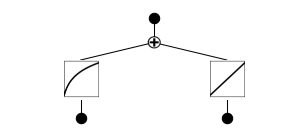

In [21]:
# grids_to_sym = [3, 5, 10, 20]
grids_to_sym = [10]

train_rmse_sym = []
test_rmse_sym = []

model = MultKAN(width=[2,1], grid=3, k=3, seed=0, device=device)
model.fit(dataset, opt='LBFGS', steps=20,
          lamb=0.01, lamb_entropy=0.1, lamb_coef=0.1, lamb_coefdiff=0.5)
model = model.prune(edge_th=0.03, node_th=0.01)

for i in range(len(grids_to_sym)):
    model = model.refine(grids_to_sym[i])
    results = model.fit(dataset, opt='LBFGS', steps=50, stop_grid_update_step=20)
    train_rmse_sym.append(results['train_loss'][-1].item())
    test_rmse_sym.append(results['test_loss'][-1].item())

model.plot()

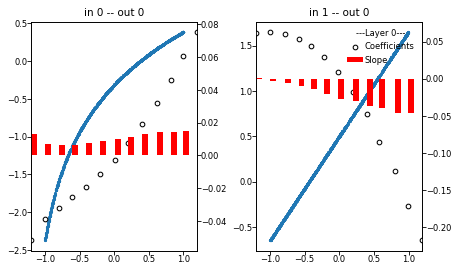

[<Figure size 450x262.5 with 4 Axes>]

In [22]:
from kan.custom_processing import plot_activation_and_spline_coefficients

plot_activation_and_spline_coefficients(model, x=dataset)

In [23]:
model.auto_symbolic()

r2 is 1.0000001192092896
fixing (0,0,0) with log, r2=1.0, c=2
r2 is 1.0000003576278687
fixing (0,1,0) with x, r2=1.0, c=1


In [24]:
from kan.utils import ex_round
ex_round(model.symbolic_formula()[0][0], 4)

1.1526*x_2 + 1.1527*log(3.88*x_1 + 4.6562) - 1.5849

Text(0, 0.5, 'Attribution score')

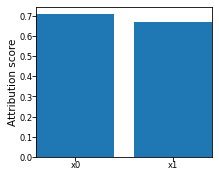

In [25]:
fig, ax = plt.subplots()
model.forward(dataset['train_input'])
scores_tot = model.feature_score
ax.bar([f"x{i}" for i in range(scores_tot.shape[0])], scores_tot.tolist())
# ax.set_xticks([f"x{i}" for i in range(score_L0.shape[0])])
ax.set_ylabel("Attribution score")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[-1.0, -1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Inflection point: -0.7994099855422974
[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]
Inflection point: None


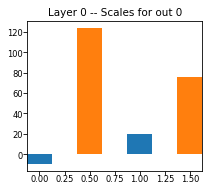

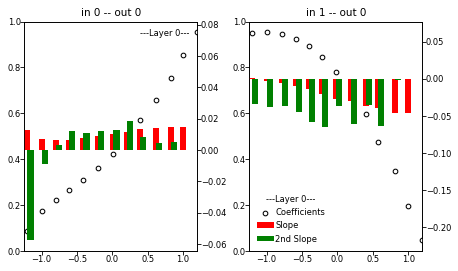

[[[tensor(-0.7994)], [None]]]


In [26]:
from kan.experiments.analysis import find_index_sign_revert

depth = len(model.act_fun)
layers_to_plot = list(range(depth))
inflection_points = []

for l in layers_to_plot:
    act = model.act_fun[l]
    ni, no = act.coef.shape[:2]
    coef = act.coef.tolist()
    inflection_points_per_layer = []

    for j in range(no):
        scale_base = act.scale_base[:,j].cpu().detach().numpy()
        scale_spline = act.scale_sp[:,j].cpu().detach().numpy()

        _, ax_scales = plt.subplots(1,1)
        ax_scales.bar([i for i in range(len(scale_base))], scale_base, label='base', width=0.25)
        ax_scales.bar([i + 0.5 for i in range(len(scale_spline))], scale_spline, label='spline', width=0.25)
        ax_scales.set_title(f'Layer {l} -- Scales for out {j}', fontsize=10)

    # Dynamic figure size and constrained layout to avoid overlaps
    fig, axs = plt.subplots(nrows=no, ncols=ni, squeeze=False,
                            figsize=(max(2.5*ni, 6), max(2.5*no, 3.5)),
                            constrained_layout=True)
    second_axs = np.zeros_like(axs)
    for i in range(ni):
        inflection_points_per_input = []
        for j in range(no):
            ax = axs[j, i]
            # Gather pre- and post-activations and sort by input
            inputs = model.spline_preacts[l][:, j, i].cpu().detach().numpy()
            outputs = model.spline_postacts[l][:, j, i].cpu().detach().numpy()
            output_spline = model.spline_postsplines[l][:, j, i].cpu().detach().numpy() # without base function values
            coef_node = coef[i][j]
            num_knot = act.grid.shape[1]
            spline_radius = int((num_knot - len(coef_node)) / 2)
            bar_width = min(act.grid[i, 1:] - act.grid[i, :-1]) / 2

            rank = np.argsort(inputs)
            # ax.plot(inputs[rank], outputs[rank], marker='o', ms=2, lw=1, label='Activations')
            # ax.plot(inputs[rank], output_spline[rank], marker='^', ms=1, lw=1, label='Splines Only')

            ax2 = ax.twinx()
            second_axs[j, i] = ax2
            ax2.scatter(act.grid[i, spline_radius:-spline_radius], coef_node,
                       s=20, color='white', edgecolor='k', label='Coefficients')
            slope = [x - y for x, y in zip(coef_node[1:], coef_node[:-1])]
            slope_2nd = [(x - y)*10 for x, y in zip(slope[1:], slope[:-1])]
            bars = ax2.bar(act.grid[i, spline_radius:-(spline_radius + 1)], slope,
                    width=bar_width, align='center', color='r', label='Slope')
            bars_2nd = ax2.bar(act.grid[i, spline_radius:-(spline_radius + 2)], slope_2nd,
                    width=bar_width, align='edge', color='g', label='2nd Slope')
            # ax2.bar_label(bars, fmt='%.2f', fontsize=6, padding=3)
            ax.set_title(f'in {i} -- out {j}', fontsize=10)

            idx_revert = find_index_sign_revert(slope_2nd, epsilon=0.)
            if idx_revert is None:
                inflection_val = None
            else:
                inflection_val = act.grid[i, spline_radius + idx_revert]
            inflection_points_per_input.append(inflection_val)

            print(f'Inflection point: {inflection_val}')
        inflection_points_per_layer.append(inflection_points_per_input)

    axs[0, 0].legend(loc='best', fontsize=8, title=f'---Layer {l}---', title_fontsize=8)
    second_axs[-1, -1].legend(loc='best', fontsize=8, title=f'---Layer {l}---', title_fontsize=8)
    inflection_points.append(inflection_points_per_layer)

    plt.show()
print(inflection_points)

[-1, -0.7994099855422974, 1]
[tensor(100), tensor(900)]


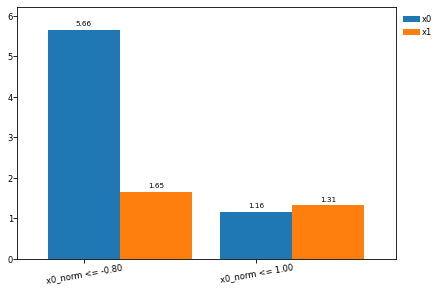

In [27]:
mask_idx = 0
mask_ip_in_range = [ip for ip in inflection_points[0][mask_idx] if ip is not None if ip > -1 if ip < 1]
mask_ip_unique = torch.unique(torch.tensor(mask_ip_in_range)).tolist()
mask_interval = [-1] + mask_ip_unique + [1]
print(mask_interval)

x_mask = dataset['train_input'][:, mask_idx]
y_vals = dataset['train_label'].ravel()

masks = [ ((x_mask > lb) & (x_mask <= ub)) for lb, ub in zip(mask_interval[:-1], mask_interval[1:])]
labels = [f'x{mask_idx}_norm <= {ub:.2f}' for lb, ub in zip(mask_interval[:-1], mask_interval[1:])]
print([sum(x) for x in masks])

scores_interval = []
scores_interval_norm = []
for mask in masks:
    if np.any(mask.numpy()):
        x_tensor_masked = dataset['train_input'][mask, :]
        x_std = torch.std(x_tensor_masked, dim=0).detach().cpu().numpy()
        model.forward(x_tensor_masked)

        score_masked = model.feature_score.detach().cpu().numpy()
        score_norm = score_masked / (x_std + 1e-6)
        scores_interval.append(score_masked)
        scores_interval_norm.append(score_norm)
    else:
        scores_interval.append(np.zeros(scores_tot.shape))
        scores_interval_norm.append(np.zeros(scores_tot.shape))

width = 0.25
fig, ax = plt.subplots(figsize=(6,4))
xticks = np.arange(len(masks)) * (width * scores_tot.shape[0] * 1.2)
xticklabels = labels
max_score = max([max(s) for s in scores_interval_norm])
for idx in range(scores_tot.shape[0]):
    bars = ax.bar(xticks + idx * width, [s[idx] for s in scores_interval_norm], width, label=f"x{idx}")
    ax.bar_label(bars, fmt='%.2f', fontsize=7, padding=3)
ax.margins(x=0.1)
ax.set_ylim(0, max_score * 1.1)

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, rotation=10, ha='center', fontsize=8)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)

plt.tight_layout()
plt.show()